# Sentiment Analysis

This project is an introduction to learning the Hugging Face framework and understanding how to make the most out of this framework to build your own LLM model. It demonstrates how to use feature extraction and fine-tuning to train a transformer model.

Ref: Natural Language Processing with transformers Book by Lewis Tunstall, Leandro von Werra and Thomas Wolf

In [ ]:
# !pip install torch torchvision torchaudio
#!pip install umap-learn


In [1]:
#import libraries
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

from huggingface_hub import notebook_login

/Users/supriyakamble/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/supriyakamble/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
all_datasets = list_datasets()
print(f" first 10 datasets available on hub {all_datasets[:10]}")

 first 10 datasets available on hub ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/supriyakamble/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
#peeking inside emotions object
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train = emotions['train']
train

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
#Dataset object behaves like Python array or list
len(train)

16000

In [7]:
#so can acces it by index
train[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
#looks like each row is a dictionary where the key is col name.
train.column_names

['text', 'label']

In [9]:
#Dataset is based on Apache Arrow which defines a typed columnar format that is more efficient than native Python.

#we can see the datatypes used by using features attribute of Dataset object
train.features
#text data type is string and label is ClassLabel object

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [10]:
#we can use several rows with slice
#Here, dictionary values will be list intead of individual elements.
train[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [11]:
#get the list of col
train['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [12]:
#to be able to use high level API for data visualisation, I will convert Datset object to Pandas df.
# using set_format() will not change underlying data format(Arrow table)

emotions.set_format(type='pandas')
df= emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
#change the label to categorical format using int2str()

def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


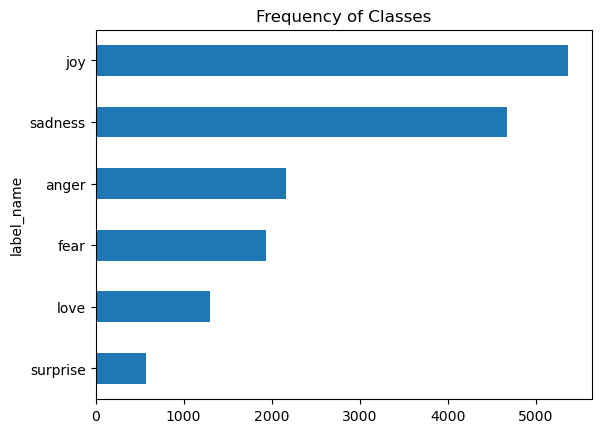

In [14]:
#distribution of  label

df['label_name'].value_counts(ascending= True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

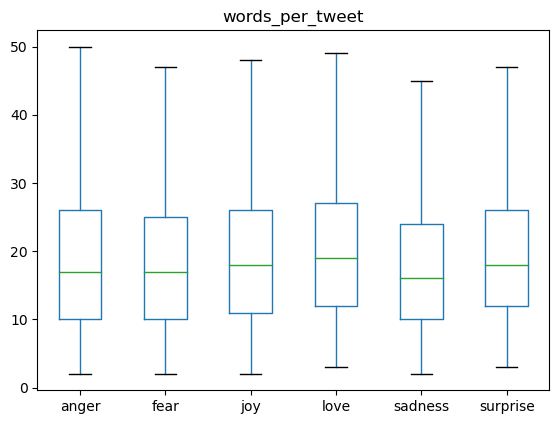

In [15]:
# how longs the tweets are? Helps to decide model. DistilBert have context size of 512 tokens. 
#Texts that are longer than models context size need to truncated, which can lead to loss in performance.

df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot('words_per_tweet', by= 'label_name', grid=False,showfliers=False)
plt.suptitle('')
plt.xlabel('')
plt.show()

Most of the tweets are around 15 words long and the longest tweet are well below Distilbert max context size.

In [16]:
#reset the output format of dataset as we dont need data frame format anymore.
emotions.reset_format()

Hugging transformers provides a convenient AutoTokenizer class that allows you to quickly load the tokenizer associated with the pretrained model. use from_pretrained() providing ID of the model 

In [17]:
model_chkpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_chkpt)

AutoTokenizer class belongs to a larger set of 'auto' classes whose job is to automatically retrieve the models configuration, pretrained weights, or vocabulary from the name of the checkpoint. It allows us to quickly switch between the models.
We can load a specific class manually also by calling the class directly such as here we can call- DistilBertTokenizer directly.

to tokanize the whole corpus we'll use map() of DatasetDict object.

map() can also be used to create new rows and columns.

In [18]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [19]:
#map operates individually on every example in the corpus and hence setting batched =True
#batch_size = None to apply tokenize() on full dataset in a single batch. Doing that ensures the input tensors
#and attention masks have the same shape globally.

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /Users/supriyakamble/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-e95f1488767fe3a7.arrow
Loading cached processed dataset at /Users/supriyakamble/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-7ff8d57a7d294edc.arrow
Loading cached processed dataset at /Users/supriyakamble/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-b66a4455bb79b8a8.arrow


In [20]:
# tokenizing would have added input_ids and attention_mask col to the dataset
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Two  options to train a model:
1. Feature Extraction - Use hidden states as features and just train a classifier on them without modifying the pretrained model.
2. Fine Tuning - train whole model end-to-end which also updates the parameters of the pretrained model.

### Feature extraction
This project is an introduction to learning the Hugging Face framework and understanding how to make the most out of this framework to build your own LLM model. It demonstrates how to use feature extraction and fine-tuning to train a transformer model.Freeze the body's weight during training and use the hidden states as features for the classifier. Advantage is that you can quickly train small or shallow model. Such model can be a neural classification layer or method that does not rely on gradients such as random forest. Its convienient if GPU is unavailable as hidden states only need to be precomputed once.

In [21]:
#AutoModel class converts the token encoding to embedding and then feed them to encoder stack to return hidden states.
device = torch.device('mps' if torch.mps else 'cpu')
model = AutoModel.from_pretrained(model_chkpt).to(device)

torch.no_grad() context manager disables the auto calculation of gradient. 

Depending on the model cofiguration output can contain several objects such as hidden states, losses or attention.

hidden state tensor have the shape: [batch_size, n_token, hidden_dim]

For classification task such as sentiment analysis, it is common practice to use hidden state associated with [CLS] token as the input feature. Can be achieved by - outputs.last_hidden_states[:,0]

In [22]:
def extract_hidden_states(batch):
    #place the model inputs on GPU
    inputs = {k:v.to(device) for k, v in batch.items()
             if k in tokenizer.model_input_names}
    #Extract last hidden state
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return{'hidden_state':last_hidden_state[:,0].cpu().numpy()}


The map() requires the processing function to return Python or Numpy objects when we are using batched inputs.

Since out model expects the tensors as inputs, the next thing is to conver input_ids and attention_mask col to the torch format.

In [23]:
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])



In [24]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched= True) #default batch_size =1000

Loading cached processed dataset at /Users/supriyakamble/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-4de34b69fa927f27.arrow
Loading cached processed dataset at /Users/supriyakamble/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-ba4356c001f3f99e.arrow
Loading cached processed dataset at /Users/supriyakamble/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-f8f1ef0ef3a60fb1.arrow


In [25]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [26]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid =np.array(emotions_hidden['validation']['hidden_state'])
y_train =np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [27]:
#Visualise training set

#scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components= 2, metric = 'cosine').fit(X_scaled)

#create df of 2D embedding
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.183660,6.212546,0
1,-3.080997,5.254228,0
2,5.041736,2.833200,3
3,-2.329899,3.067278,2
4,-3.309169,3.315176,3


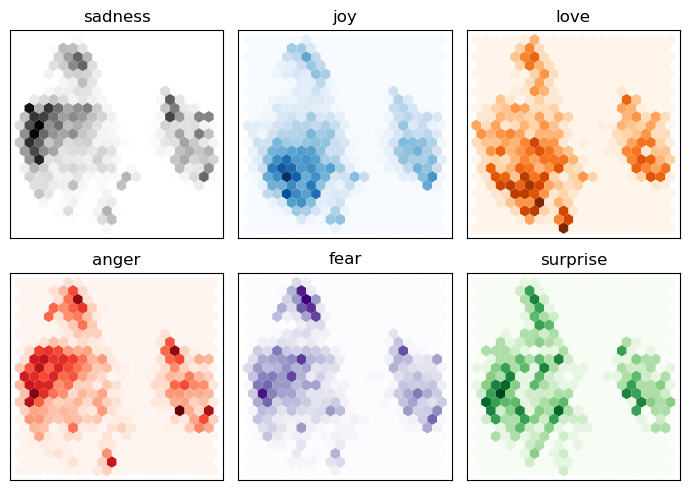

In [28]:
fig, axes = plt.subplots(2, 3,figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap = cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

NOTE: Its only a projection onto a lower dimensional space. Just because some categories overlap does not mean that they are not separable in the original space. Conversely , if they are separable in the projected space they will be separable in the original space.

In [29]:
#Train Classifier
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

Still comparatively better performance than DummyClassifier. Remember we did not balanced class at the beginning.

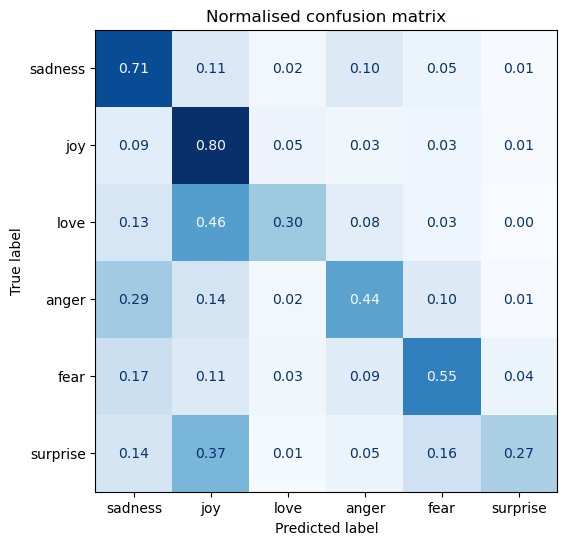

In [30]:
#confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format=".2f", ax= ax, colorbar=False)
    plt.title('Normalised confusion matrix')
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Anger and fear are mostly confused with sadness. Love and surprise are frequently mistaken for joy.

### Fine Tuning

Train the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. The initial hidden states adapt during the training to decrease the model loss and thus increase its performance.

Trainer API from hugging face simplifies training loop.

AutoModelForSequenceClassificaition model has a classification head on top of the pretrained model outputs which can be easily trained with base model.

In [31]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_chkpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

TrainingArguments class stores gives you fine-grained control over the training and evaluation. output_dir is most important to specify as it will store all the artifacts from the training.

In [33]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_chkpt}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=2,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size= batch_size,
                                 weight_decay= 0.01,
                                 evaluation_strategy='epoch',
                                 disable_tqdm=False,
                                 logging_steps=logging_steps,
                                 push_to_hub=True,
                                 log_level='error')


In [ ]:
notebook_login()

In [36]:
trainer = Trainer(model=model, args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=emotions_encoded['train'],
                 eval_dataset=emotions_encoded['validation'],
                 tokenizer=tokenizer)

trainer.train()

/Users/supriyakamble/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.828600,0.312486,0.904000,0.903245
2,0.246700,0.213941,0.926000,0.925988


TrainOutput(global_step=500, training_loss=0.5376043319702148, metrics={'train_runtime': 1842.4049, 'train_samples_per_second': 17.369, 'train_steps_per_second': 0.271, 'total_flos': 720342861696000.0, 'train_loss': 0.5376043319702148, 'epoch': 2.0})

predict() of Trainer class returns several useful objects that can be used for evaluation. The output of predict() is a PredictionOutput object that contains arrays of predictions and label_ids, along with the metric passed to the trainer.

In [37]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [38]:
preds_output.metrics

{'test_loss': 0.21394135057926178,
 'test_accuracy': 0.926,
 'test_f1': 0.9259878164722063,
 'test_runtime': 7.3691,
 'test_samples_per_second': 271.405,
 'test_steps_per_second': 4.342}

The output of the predict() also contains the  raw predictions for each class. We can decode this predictions greedily using np.argmax(). This yields the predicted labels and has the same format as the label returned by the scikit-learn models in feature based approach.

In [39]:
y_preds= np.argmax(preds_output.predictions, axis=1)

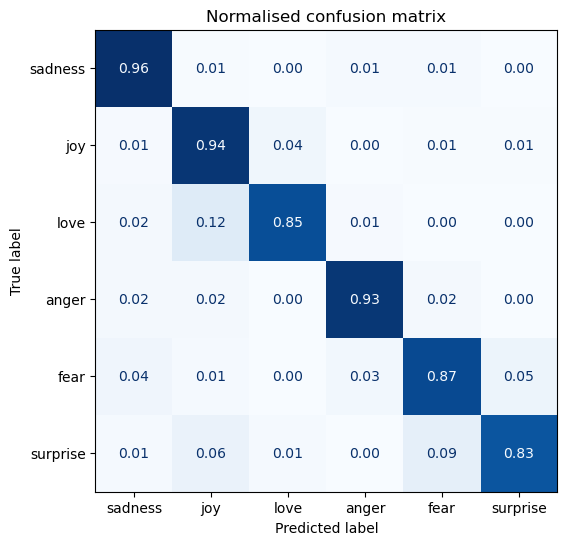

In [40]:
plot_confusion_matrix(y_preds,y_valid, labels)

### Error Analysis

A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned.

In [43]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    #place all input tensors on the same device as the model
    inputs ={k:v.to(device) for k, v in batch.items()
            if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis =-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')
        
    #Place outputs on CPU for compaitability with other datasets columns
    return {'loss': loss.cpu().numpy(),
           'predicted_label': pred_label.cpu().numpy()}

In [44]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [46]:
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)

In [47]:
df_test.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.107750
882,i feel badly about reneging on my commitment t...,love,sadness,5.038267
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.986557
1801,i feel that he was being overshadowed by the s...,love,sadness,4.933781
1274,i am going to several holiday parties and i ca...,joy,sadness,4.895170
1950,i as representative of everything thats wrong ...,surprise,sadness,4.793488
1683,i had applied for a job and they had assured m...,anger,joy,4.695988
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.661983
765,i feel super awkward and out of place right now,joy,sadness,4.619122
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.577143


Model predicted some of the labels incorrectly. On the other hand it seems that there are quite few examples with no clear class which might be either mislabeled or require new class altogether.